# Tutorial: Implementing the Morris-Lecar Neuron Model in Python
This notebook guides you through implementing the Morris-Lecar model in Python. The Morris-Lecar model is a reduced version of the Hodgkin-Huxley model with two conductances and a leak current, capturing key neuronal dynamics in a more tractable form.

## Overview of the Morris-Lecar Model
- **Voltage variable (`V`)**: Represents the membrane potential of the neuron.
- **Recovery variable (`n`)**: Represents the gating of potassium channels.
- **Instantaneous calcium current**: Provides rapid depolarizing input.
- **Slower potassium current**: Mediates repolarization slowly.
- **Leak current**: Simple passive current stabilizing the membrane.

*This high-level view introduces the key components that interact to produce neuronal oscillations.*


## Step 1: Setting Up the Required Packages
Import the necessary libraries for numerical computation, plotting, and differential equation integration.

In [ ]:
import numpy as np       # For efficient numerical arrays and math operations
import matplotlib.pyplot as plt  # For creating plots and visualizations
from scipy.integrate import odeint  # For integrating systems of ODEs

## Step 2: Defining Model Parameters
Define biophysical parameters such as membrane capacitance, ion conductances, reversal potentials, and input current.
These constants govern the speed and amplitude of the neuron's response.

In [ ]:
# Model Parameters
CM = 20.0       # µF/cm²: Membrane capacitance controls how fast voltage changes

g_Ca = 4.4     # mS/cm²: Calcium conductance drives inward current
ng_K  = 8.0     # mS/cm²: Potassium conductance for outward current
ng_L  = 2.0     # mS/cm²: Leak conductance for passive stability

E_Ca = 120.0   # mV: Calcium reversal potential
E_K  = -84.0   # mV: Potassium reversal potential
E_L  = -60.0   # mV: Leak reversal potential

phi     = 0.04             # Temperature scaling factor for gating dynamics
V1, V2 = -1.2, 18.0        # Parameters for calcium activation curve
V3, V4 = 2.0, 30.0         # Parameters for potassium activation curve
I_input = 40.0             # µA/cm²: External current stimulus

## Step 3: Implementing the Gating Functions
Gating functions describe how ion channel probabilities depend on membrane voltage.
- `m_inf(V)`: Steady-state activation for calcium channels (instantaneous).
- `n_inf(V)`: Steady-state activation for potassium channels.
- `tau_n(V)`: Voltage-dependent time constant for potassium gating.

In [ ]:
# Ionic Gates
def m_inf(V):
    return 0.5 * (1 + np.tanh((V - V1) / V2))  # Instantaneous calcium activation

def n_inf(V):
    return 0.5 * (1 + np.tanh((V - V3) / V4))  # Steady-state potassium activation

def tau_n(V):
    return 1 / np.cosh((V - V3) / (2 * V4))    # Time constant for n dynamics

## Step 4: Implementing Ionic Currents
Calculate each ionic current using Ohm’s law: `I = g * (V - E)`.
- `I_Ca`: Calcium current dependent on `m_inf`.
- `I_K`: Potassium current dependent on `n`.
- `I_L`: Leak current.

In [ ]:
# Ionic Currents
def I_leak(V):            #Leak current (mA/cm²)
                          #V: membrane potential (mV)
    return gL * (V-EL)
def I_K(V, n):           #Potassium current (mA/cm²)
                         #V: membrane potential (mV)
                         #n: potassium activation variable (0-1)
    return gK * n * (V-EK)
def I_Ca(V):             #Calcium current (mA/cm²)
                         #V: membrane potential (mV)
    return gCa * m_inf(V) * (V-ECa)

## Step 5: Defining the Differential Equations
Formulate the two coupled ODEs:
1. **dV/dt**: Net current divided by membrane capacitance.
2. **dn/dt**: Relaxation of `n` towards its steady state with time constant `tau_n`.

In [ ]:
#Vector field for Morris-Lecar model
def neuronVF(X, t, I_input=0):   #X: state vector [V, n]
                                 #t: time (ms)
                                 #I_input: external applied current (μA/cm²)
    V,n = X
    # Membrane potential dynamics (dV/dt)
    # Current balance equation: C*dV/dt = I_input - I_ionic
    dV = (I_input - I_leak(V) - I_K(V, n) - I_Ca(V))/CM
    # Potassium activation dynamics (dn/dt)
    # First-order kinetics with voltage-dependent time constant
    dn = phi * (n_inf(V) - n)/tau_n(V)
    return dV,dn

## Step 6: Setting Up Simulation Parameters
Choose the time span and initial conditions:
- `t_span`: Time points for integration (in ms).
- `X0`: Initial voltage and activation values.

In [ ]:
# simulation parameters
t_span = np.arange(0.0, 400.0, 0.1) # time(ms), samples every 0.1ms
I_input = 60 # external current (μA/cm²)
X0 = [-0, 0.25] # initial condition [V0,n0]


## Step 7: Solving the Differential Equations
Use `odeint` to compute the time evolution of `V` and `n`.

In [ ]:
# run the simulation using SciPy's odeint solver
# the lambda function adapts our neuronVF to the format expected by odeint
X = odeint(lambda X,t: neuronVF(X,t,I_input=I_input), X0, t_span)

## Step 8: Visualizing the Results
Plot the membrane potential, activation variable, and phase portrait for one input current.
These plots highlight how the system evolves in both time and state space.

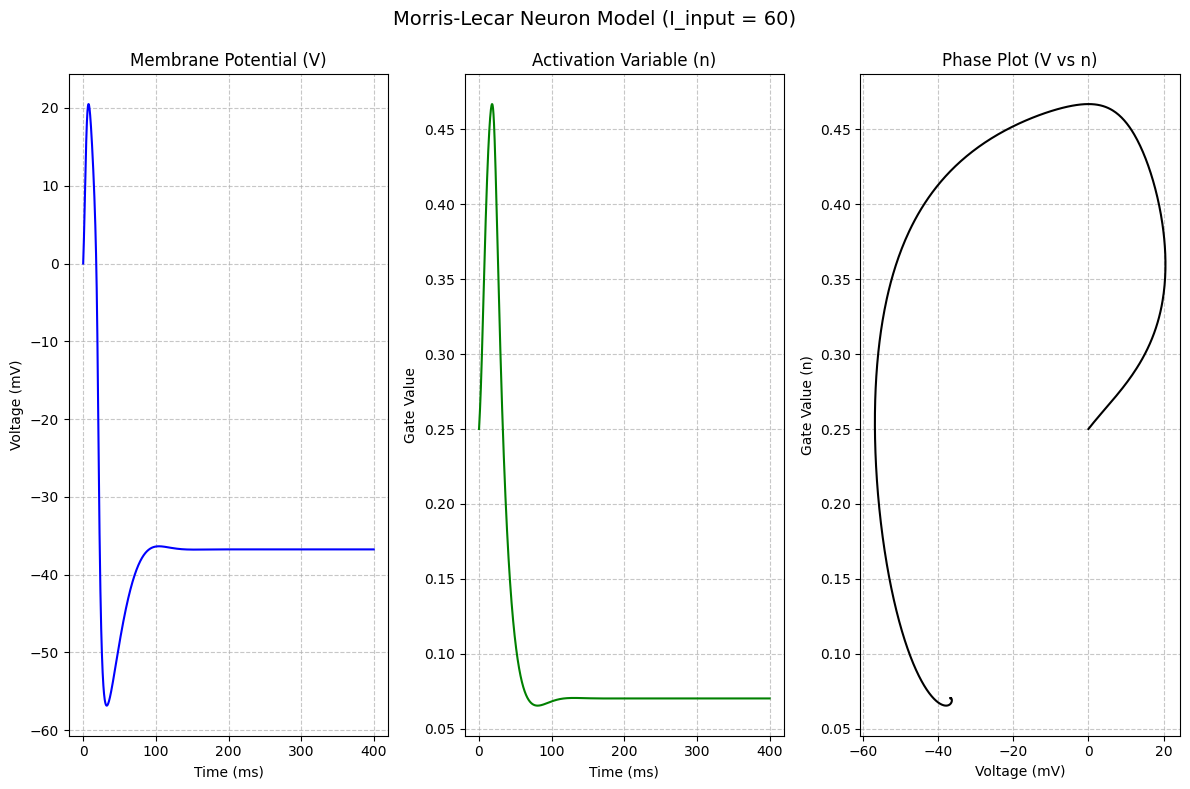

In [ ]:
# create a single figure with subplots
# X now contains the solution, with:
# X[:, 0] = voltage V at all time points
# X[:, 1] = potassium activation n at all time points
# Create a single figure with subplots
plt.figure(figsize=(12, 8))

# create three subplots in a single row
# voltage vs time
ax1 = plt.subplot(1, 3, 1)
ax1.plot(t_span, X[:, 0], 'b')
ax1.set_title('Membrane Potential (V)')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax1.grid(True, linestyle='--', alpha=0.7)

# n vs time (potassium activation series)
ax2 = plt.subplot(1, 3, 2)
ax2.plot(t_span, X[:, 1], 'g')
ax2.set_title('Activation Variable (n)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Gate Value')
ax2.grid(True, linestyle='--', alpha=0.7)

# phase plot (V vs n)
ax3 = plt.subplot(1, 3, 3)
ax3.plot(X[:, 0], X[:, 1], 'k')
ax3.set_title('Phase Plot (V vs n)')
ax3.set_xlabel('Voltage (mV)')
ax3.set_ylabel('Gate Value (n)')
ax3.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle(f'Morris-Lecar Neuron Model (I_input = {I_input})', fontsize=14)
plt.subplots_adjust(top=0.9)

plt.show()

### Results for Different Input Currents
Below, we vary `I_input` = 20, 60, 80, and 90 µA/cm² within the existing model to observe differences in spiking behavior:

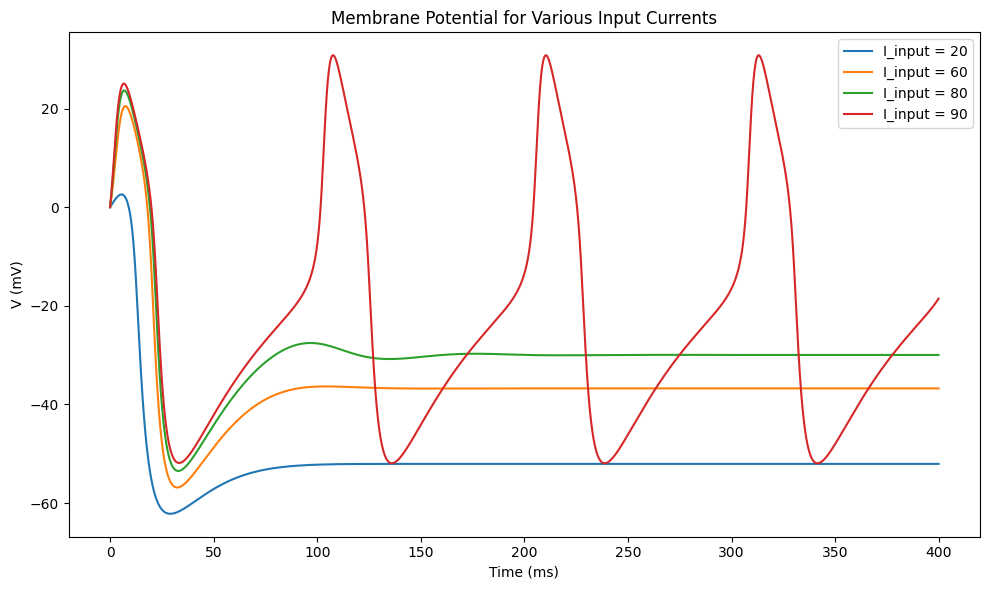

In [ ]:
plt.figure(figsize=(10, 6))
for I_input in [20, 60, 80, 90]:
    solution = odeint(neuron_dynamics, X0, t_span)
    V_trace = solution[:, 0]
    plt.plot(t_span, V_trace, label=f'I_input = {I_input}')

plt.title('Membrane Potential for Various Input Currents')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.legend()
plt.tight_layout()
plt.show()

Interpretation:
- **I_input = 20**: Subthreshold regime; no action potentials.
- **I_input = 60**: Onset of regular spiking.
- **I_input = 80**: Higher frequency spiking.
- **I_input = 90**: Even faster oscillations, possible changes in spike amplitude.

Observe how lower currents (e.g., 20) remain subthreshold, while higher currents (e.g., 80, 90) produce regular spiking.

### Activation Variable Results for Different Input Currents
Plot the potassium activation variable `n` over time for each input current:

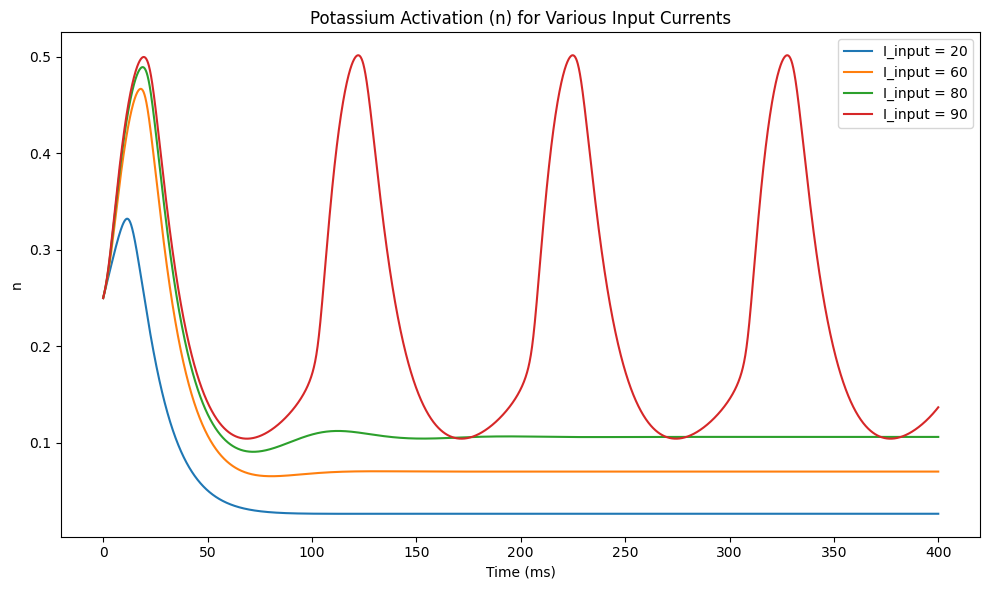

In [ ]:
plt.figure(figsize=(10, 6))
for I_input in [20, 60, 80, 90]:
    solution = odeint(neuron_dynamics, X0, t_span)
    n_trace = solution[:, 1]
    plt.plot(t_span, n_trace, label=f'I_input = {I_input}')

plt.title('Potassium Activation (n) for Various Input Currents')
plt.xlabel('Time (ms)')
plt.ylabel('n')
plt.legend()
plt.tight_layout()
plt.show()

**Interpretation (Activation):**
- **I_input = 20**: `n` remains near baseline, reflecting minimal channel activation.
- **I_input = 60**: `n` exhibits regular oscillations aligned with spike times.
- **I_input = 80** and **90**: `n` oscillates with higher amplitude and frequency, indicating stronger and faster channel activation.

### Phase Plot Trajectories for Different Input Currents
Overlay phase plot trajectories (`V` vs `n`) for each input current to compare limit cycles:

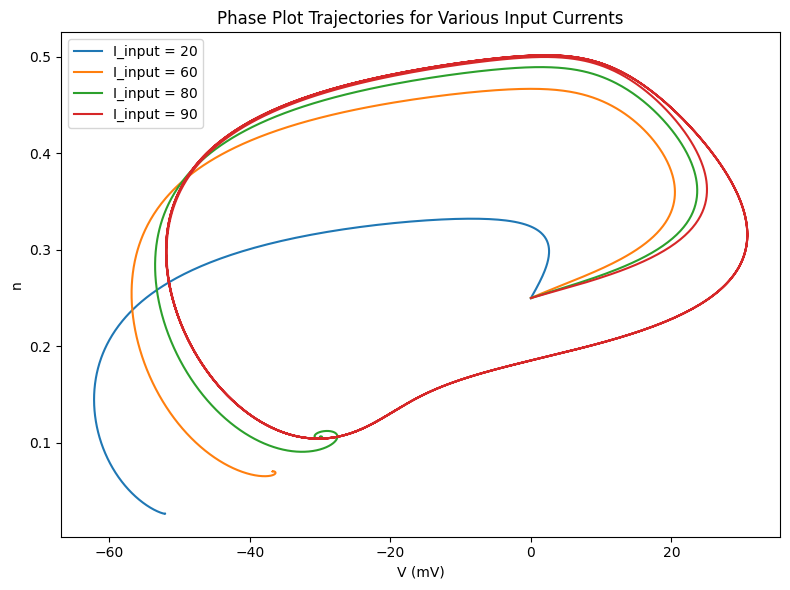

In [ ]:
plt.figure(figsize=(8, 6))
for I_input in [20, 60, 80, 90]:
    solution = odeint(neuron_dynamics, X0, t_span)
    V_trace = solution[:, 0]
    n_trace = solution[:, 1]
    plt.plot(V_trace, n_trace, label=f'I_input = {I_input}')

plt.title('Phase Plot Trajectories for Various Input Currents')
plt.xlabel('V (mV)')
plt.ylabel('n')
plt.legend()
plt.tight_layout()
plt.show()


**Interpretation (Phase Plots):**
- **I_input = 20**: Trajectory remains near the fixed point, indicating no oscillation.
- **I_input = 60**: Small limit cycle appears, corresponding to onset of spiking.
- **I_input = 80** and **90**: Larger, faster cycles reflect increased oscillation amplitude and frequency.